In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from astropy.stats import bootstrap as bootstrap
from statsmodels.tsa.ar_model import AutoReg
import math
import common_func as cf
import import_ipynb
from check_ln2 import *

In [8]:

# Function to fit data to a normal distribution, using either MLE or MOM
def fitNormal(data, method):
    assert method == 'MLE' or method == 'MOM', "method must = 'MLE' or 'MOM'"

    xbar, std, skew = cf.findmoments(data)

    if method == 'MLE':
        mu, sigma = ss.norm.fit(data)

    elif method == 'MOM':
        mu = xbar
        sigma = std

    return mu, sigma

# Function to make QQ plot for normal data with correlation test
def NormalPPCT(data, mu, sigma, title, figname):
    x_sorted = np.sort(data)
    p_observed = np.arange(1, len(data) + 1, 1) / (len(data) + 1)
    x_fitted = ss.norm.ppf(p_observed, mu, sigma)
    rho = np.corrcoef(x_sorted, x_fitted)[0, 1]

    plt.scatter(x_sorted, x_fitted, color='b')
    plt.plot(x_sorted, x_sorted, color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.savefig(figname)
    plt.show()

    # Estimate p-value of corelation coefficient
    rhoVector = np.zeros(10000)
    for i in range(10000):
        x = ss.norm.rvs(mu, sigma, len(data))
        rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0, 1]

    count = 0
    for i in range(len(rhoVector)):
        if rho < rhoVector[i]:
            count = count + 1

    p_value = 1 - count / 10000

    return rho, p_value
    
#MannKendall Test

# function for determining tie groups and corresponding number of ties.
def count_ties(x):
    ties = []
    y = x
    while len(x) > 0: 
        ties.append(np.where(x == x[0])[0].size)
        x = np.delete(x, np.where(x == x[0]))
    ties=np.array(ties)
    return ties

#function for calculating variance in mann kendall test
def var(x):
    n = len(x)
    var = n * (n - 1) * (2 * n + 5)
    e = count_ties(x)
    extent_sum = np.sum(e * (e - 1) * (2 * e + 5))
    return  (var - extent_sum)/18

# function for testing pvalue and critical value of mann kendall test
def mktest(z):
    alpha = 0.1    # alpha = 0.05 
    CritVal = np.abs(ss.norm.ppf(alpha / 2))
    pvalue = ss.norm.sf(np.abs(z)) * 2 
    print('pvalue:',pvalue)
# Reject H0 if |Z-Score| > CritVal and, equivalently, if p-value < alpha/2
    reject1 = CritVal < np.abs(z)
    reject2 = pvalue < alpha
    if reject1:
        return 'Yes'
    return 'No'
# Mann Kendall Test
def main_mk(maxQ):
    T = 0
    data = np.log(maxQ)
    for j in range(len(data)-1):
        t = data[j] - (data[j+1:])
        T += (np.where(t < 0))[0].size - (np.where(t > 0))[0].size
    variance = var(data)
    if T > 0:
        z = (T - 1)/(np.sqrt(variance))
    else:
        z = (T + 1)/(np.sqrt(variance))
    print('Z_value:',z)
    trend = mktest(z)
    print('Is there a monotonic trend?',trend,'\n')

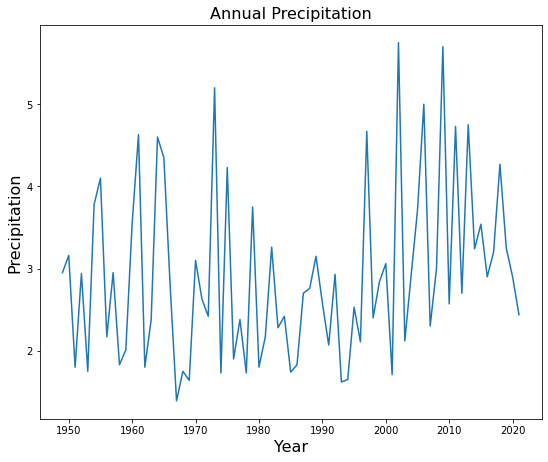

In [9]:
# log transformation?
mu, sigma = fitNormal(np.log(maxQ),'MOM')
rho_log, p_value_log = NormalPPCT(np.log(maxQ), mu, sigma, 'Log Normal PPCT', 'LogNormalPPCT.png')
print(rho_log, p_value_log)

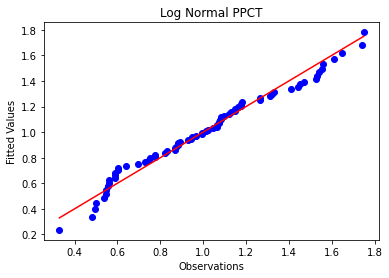

0.989590871288297 0.24980000000000002


In [10]:
def acf_pacf(maxQ):
    sm.graphics.tsa.plot_acf(np.log(maxQ))
    plt.show()
    sm.graphics.tsa.plot_pacf(np.log(maxQ))
    plt.show()

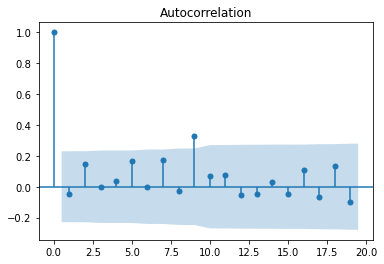

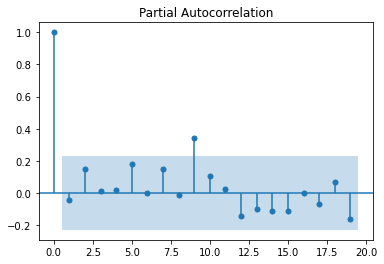

In [11]:
def test_reg(maxQ):
    fitted = pd.DataFrame()
    fitted["Annual_max_preciption"]= np.log(maxQ)
    fitted['Year'] = yearMaxQ

    mod = smf.ols(formula='Annual_max_preciption~ Year', data=fitted)
    results = mod.fit()
    print(results.summary(alpha=0.1))

                              OLS Regression Results                             
Dep. Variable:     Annual_max_preciption   R-squared:                       0.049
Model:                               OLS   Adj. R-squared:                  0.035
Method:                    Least Squares   F-statistic:                     3.648
Date:                   Sun, 27 Feb 2022   Prob (F-statistic):             0.0602
Time:                           08:28:37   Log-Likelihood:                -24.507
No. Observations:                     73   AIC:                             53.01
Df Residuals:                         71   BIC:                             57.59
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------
Intercept     -6.2205 

Z_value: 1.8242370217284039
pvalue: 0.06811624686909405
Is there a monotonic trend? Yes 



In [ ]:
Data = pd.read_csv('precip.csv')
maxQ, yearMaxQ = cf.annual_max(Data)
# Get just the year vector for annual maxima as numpy array
fig = plt.figure()
plt.plot(yearMaxQ, maxQ)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Precipitation', fontsize=16)
plt.title('Annual Precipitation', fontsize=16)
fig.set_size_inches([9, 7.25])
fig.savefig('Annual Precipitation', dpi=300)
plt.show()
